# Check the GPU

In [1]:
!nvidia-smi

Wed Apr 20 18:09:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    74W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import neccessary packages

In [10]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as tfl
import imageio
import os
import matplotlib.pyplot as plt

# Mount dataset from Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Unzip dataset

In [4]:
%cd /content/gdrive/MyDrive/ComputerVision/UNet
if not (os.path.isdir("data")):
  !unzip data.zip

/content/gdrive/MyDrive/ComputerVision/UNet


In [5]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as tfl
import imageio
import os

# Set appropriate constant for the UNet framework

In [6]:
IMAGE_SIZE = (96, 128)
INITIAL_FILTER_NUM = 64
CLASS_NUM = 23
BATCH_SIZE = 32
BUFFER_SIZE = 500
EPOCH_NUM = 50

#Create checkpoint folder
if not os.path.isdir("checkpoint"):
  os.mkdir("checkpoint")
CHECKPOINT_PATH = "checkpoint/checkpoint.ckpt"
img_path = "data/CameraRGB/"
mask_path = "data/CameraMask/"

# Define function to preprocess the dataset

In [7]:
def process_path(img_path, mask_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels= 3)
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.io.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis = -1, keepdims= True)

    return img, mask

def preprocess_dataset(img, mask):
    #Resize the dataset to IMAGE_SIZE
    img = tf.image.resize(img, size = IMAGE_SIZE, method = 'nearest')
    mask = tf.image.resize(mask, size = IMAGE_SIZE, method = 'nearest')
    return img, mask


# Define the function used in the UNet architecture


In [8]:
def downsampling_block(input, filters_num, dropout_rate = 0, max_pooling = False):
    '''
    This function will serve as a downsampling bnlock in the unet. It has 2 convolution layer, 1 dropout layer, and 1 max pooling layer (optional)
    Return the tensor before doing the last maxpooling (for the skip connection) and the tensor after doing pooling
    '''
    model = keras.Sequential(
        [tfl.Conv2D(filters= filters_num, kernel_size=3,
                    kernel_initializer='he_normal', padding='same', activation = 'relu'),
         tfl.Conv2D(filters= filters_num, kernel_size=3,
                    kernel_initializer='he_normal', padding='same', activation = 'relu'),
         tfl.Dropout(rate = dropout_rate)
         ])
    next_block = before_pooling = model(input)
    if max_pooling:
        next_block = tfl.MaxPool2D(pool_size=(2,2), strides=2)(before_pooling)
    return next_block, before_pooling

def upsampling_block(expansive_tensor, contractive_tensor, filters_num):
    contractive_tensor = tfl.Conv2DTranspose(filters = filters_num, kernel_size=3,
                                             strides = (2,2), padding = 'same')(contractive_tensor)
    input = tfl.Concatenate(axis = 3)([expansive_tensor, contractive_tensor])
    
    model = keras.Sequential([
        tfl.Conv2D(filters= filters_num, kernel_size=3, padding = 'same', activation='relu',
                   kernel_initializer='he_normal'),
        tfl.Conv2D(filters=filters_num, kernel_size=3, padding='same', activation='relu',
                   kernel_initializer='he_normal')
    ])
    output = model(input)
    return output

def unet_architecture(input_size, initial_filters_num, n_classes):
    #Building U-Net based on the upsampling block and downsampling block
    input = keras.Input(shape=input_size)
    dropout_rate = 0.3

    #Downsampling the tensor
    down1, skip1 = downsampling_block(input, initial_filters_num * 1, dropout_rate, True)
    down2, skip2 = downsampling_block(down1, initial_filters_num * 2, dropout_rate, True)
    down3, skip3 = downsampling_block(down2, initial_filters_num * 4, dropout_rate, True)
    down4, skip4 = downsampling_block(down3, initial_filters_num * 8, dropout_rate, True)
    down5, skip5 = downsampling_block(down4, initial_filters_num * 16, dropout_rate, True)

    #Upsampling the tensor
    up4 = upsampling_block(skip4, skip5, initial_filters_num * 8)
    up3 = upsampling_block(skip3, up4, initial_filters_num * 4)
    up2 = upsampling_block(skip2, up3, initial_filters_num * 2)
    up1 = upsampling_block(skip1, up2, initial_filters_num * 1)

    last_layers = keras.Sequential([
        tfl.Conv2D(initial_filters_num, kernel_size=3, activation='relu',
                   padding='same', kernel_initializer='he_normal'),
        tfl.Conv2D(n_classes, kernel_size=1, padding='same')
    ])
    output = last_layers(up1)

    model = keras.Model(input, output)
    return model


In [9]:
img_list = os.listdir(img_path)
mask_list = os.listdir(mask_path)
img_list = [img_path + img_dir for img_dir in img_list]
mask_list = [mask_path + mask_dir for mask_dir in mask_list]

#Turn the dataset to tensor
img_list_tf = tf.constant(img_list)
mask_list_tf = tf.constant(mask_list)
dataset = tf.data.Dataset.from_tensor_slices((img_list_tf, mask_list_tf))

img_list_temp = tf.gather(img_list_tf, 0)
mask_list_temp = tf.gather(mask_list_tf, 0)

dataset = dataset.map(process_path)
dataset = dataset.map(preprocess_dataset)

input_shape = IMAGE_SIZE + (3,)

unet = unet_architecture(input_shape, INITIAL_FILTER_NUM, CLASS_NUM)
unet.summary()

#Set up the specs for compile
optimizer = keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

unet.compile(optimizer=optimizer, loss=loss, metrics=metrics)

dataset = dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
cp_callback = keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT_PATH,
                                            save_weights_only=True,
                                            verbose = 1)
history = unet.fit(dataset, epochs=EPOCH_NUM, callbacks=[cp_callback])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 sequential (Sequential)        (None, 96, 128, 64)  38720       ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 48, 64, 64)   0           ['sequential[0][0]']             
                                                                                                  
 sequential_1 (Sequential)      (None, 48, 64, 128)  221440      ['max_pooling2d[0][0]']      

# Plot the accuracy accross epochs

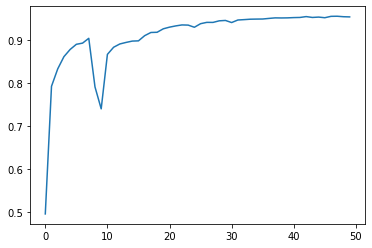

In [11]:
plt.plot(history.history['accuracy'])

# Display prediction

In [65]:
def process_prediction_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_prediction_and_true_mask(model, dataset, num = 1):
  for img, mask in dataset.take(num):
    prediction = model.predict(img)
    
    prediction = process_prediction_mask(prediction)
    img = img[0]
    mask = mask[0]

    plt.figure(figsize = (20,20))
    plt.subplot(num, 3, 1)
    plt.title("Image")
    plt.imshow(keras.preprocessing.image.array_to_img(img))
    
    plt.subplot(num, 3, 2)
    plt.title("True mask")
    plt.imshow(keras.preprocessing.image.array_to_img(mask))
    
    plt.subplot(num, 3, 3)
    plt.title("Predicted_mask")
    plt.imshow(keras.preprocessing.image.array_to_img(prediction))

    plt.axis("off")
  plt.show()
    


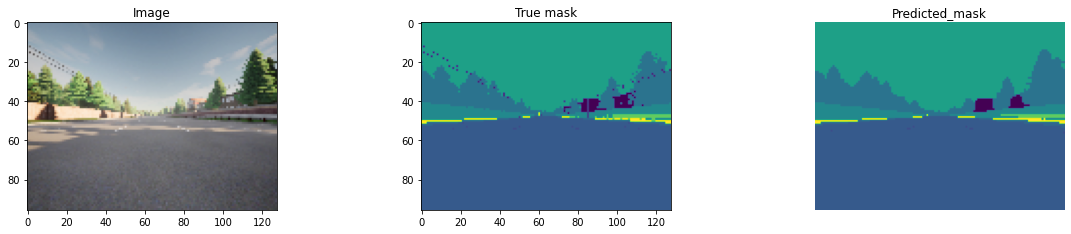

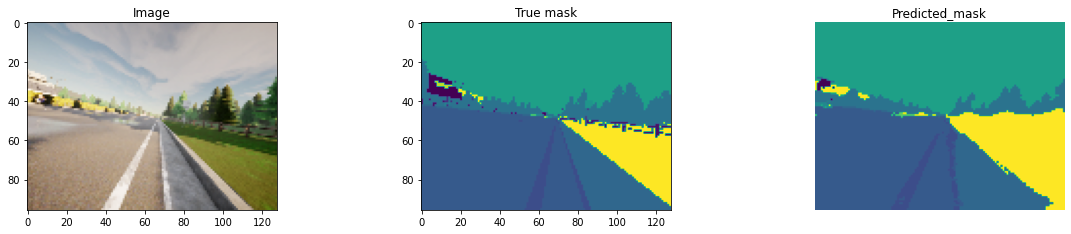

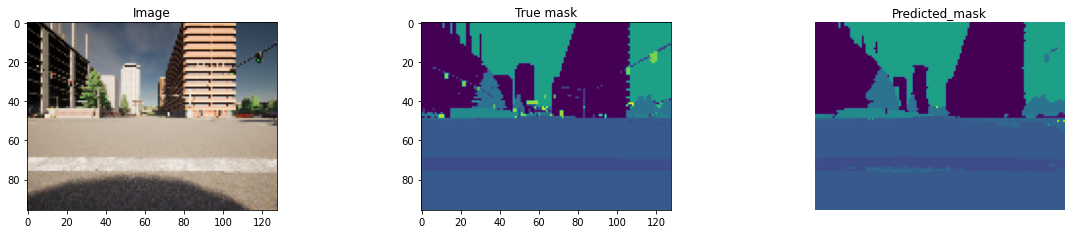

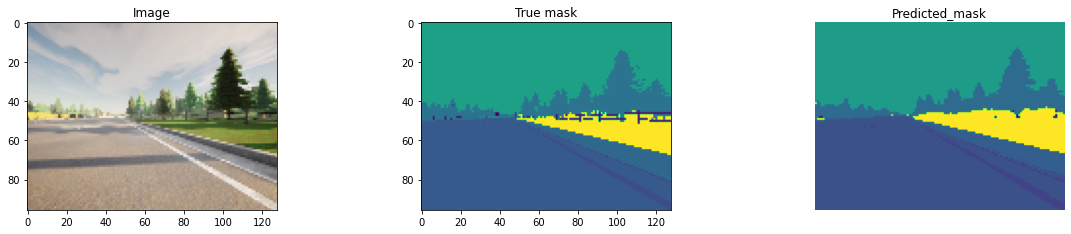

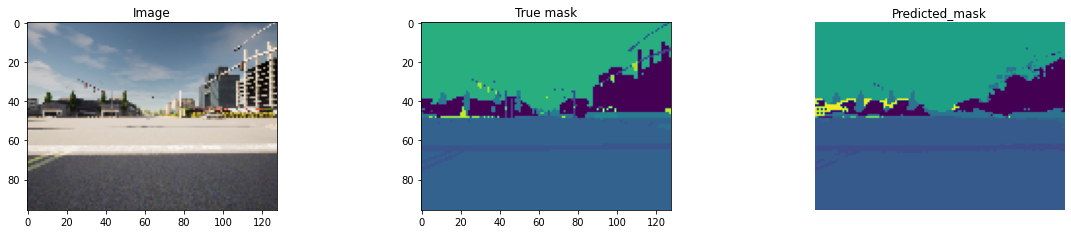

In [66]:
show_prediction_and_true_mask(unet, dataset, 5)